In [1]:
import string
import nltk
from liwc import Liwc
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from nltk.stem.porter import *
from collections import Counter
from tqdm import tqdm_notebook
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 
from nltk.tokenize import word_tokenize
import multiprocessing
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('classic')
orange, purple, elm ='#FFCC00', '#666599', '#217C7E'
blue, red, grey, green ='#336699', '#9A3334', '#AAAAAA', '#335333'
%matplotlib inline
mydpi=600
s=12

__author__ = 'HK Dambanemuya'
__version__ = 'Python3'

In [2]:
print ("Reading News...")
news = pd.read_csv("../Data/Fusion/news.csv")
news = news[news['length']>100]
news['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(news['date'])]

print ("Reading Blogs...")
blogs = pd.read_csv("../Data/Fusion/blogs.csv")
blogs = blogs[blogs['length']>100]
blogs['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(blogs['date'])]

print ("Reading Discussions...")
discussions = pd.read_csv("../Data/Fusion/discussions.csv")
discussions = discussions[discussions['length']>100]
discussions['date'] = [datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in tqdm_notebook(discussions['date'])]

Reading News...



Reading Blogs...



Reading Discussions...


In [3]:
# Use the same sorted date list across all three datasets
dates = sorted(list(set(news['date']).union(set(blogs['date'])).union(set(discussions['date']))))[1:-1]
dates_ = [date[5:].replace('-','/') for date in dates]

In [4]:
ppe_n = news[(news['topic'].str.contains('face mask')) | (news['topic'].str.contains('hand sanitizer'))]
ppe_b = blogs[(blogs['topic'].str.contains('face mask')) | (blogs['topic'].str.contains('hand sanitizer'))]
ppe_d = discussions[(discussions['topic'].str.contains('face mask')) | (discussions['topic'].str.contains('hand sanitizer'))]
ppe_news_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in ppe_n['date']])
ppe_blogs_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in ppe_b['date']])
ppe_discussions_frequency = Counter([datetime.strftime(pd.to_datetime(date), '%Y-%m-%d') for date in ppe_d['date']])

In [5]:
def get_topic_frequency_by_media(topic_mapping):
    dates = sorted(topic_mapping.keys())
    news_v, blogs_v, discussions_v = [], [], []
    for date in dates:
        news_v.append(topic_mapping.get(date)[0])
        blogs_v.append(topic_mapping.get(date)[1])
        discussions_v.append(topic_mapping.get(date)[2])  
    return news_v, blogs_v, discussions_v

In [6]:
ppe_topic_map = {}
for date in tqdm_notebook(sorted(dates)):
    ppe_topic_map[date] = [ppe_news_frequency.get(date, 0), 
                       ppe_blogs_frequency.get(date, 0), 
                       ppe_discussions_frequency.get(date, 0)]

ppe_news_v, ppe_blogs_v, ppe_discussions_v = get_topic_frequency_by_media(ppe_topic_map)
assert len(ppe_news_v) == len(ppe_blogs_v) == len(ppe_discussions_v)
n= len(ppe_news_v)

In [7]:
ppe_news_r = pd.Series(ppe_news_v).rolling(7, win_type='triang').sum()
ppe_blogs_r = pd.Series(ppe_blogs_v).rolling(7, win_type='triang').sum()
ppe_discussions_r = pd.Series(ppe_discussions_v).rolling(7, win_type='triang').sum()

In [8]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

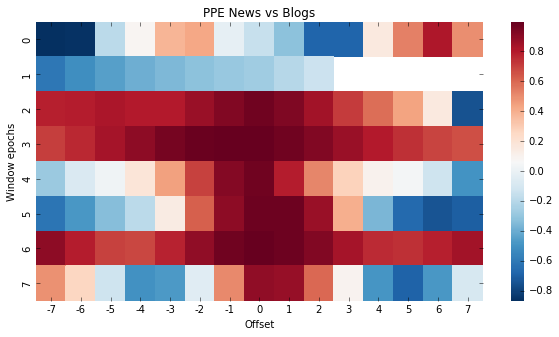

In [9]:
# Windowed time lagged cross correlation
# seconds = 5
# fps = 30
df = pd.DataFrame()
df['news'] = ppe_news_r
df['blogs'] = ppe_blogs_r

no_splits = 8
samples_per_split = df.shape[0]/no_splits
rss=[]

for t in range(0, no_splits):
    d1 = df['news'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['blogs'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-7,8)]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'PPE News vs Blogs', xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels(range(-7,8));

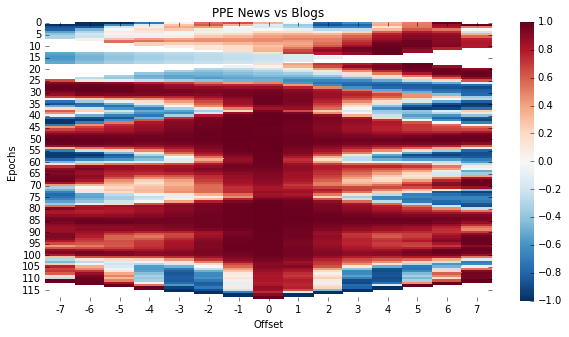

In [12]:
# Rolling window time lagged cross correlation
window_size = 14 #samples
t_start = 0 # start at 0
t_end = t_start + window_size
step_size = 1
rss=[]
while t_end < n+window_size:
    d1 = df['news'].iloc[t_start:t_end]
    d2 = df['blogs'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-7,8)]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'PPE News vs Blogs', xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels(range(-7,8));